### DATA PREP 

In [1]:
import pandas as pd 
import numpy as np
import warnings
warnings. filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from model_support import normalize
from model_support import set_global_determinism
set_global_determinism()
from matplotlib.dates import DateFormatter
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import seed
from xgboost import XGBRegressor
import tensorflow as tf
tf.random.set_seed(0) 
seed(0)

In [2]:
# dataset import
df =  pd.read_csv('original_set_raw.csv')
df2 = normalize(df)
dataset =df2[df2.columns[0:9]].to_numpy()

In [3]:
def split_sequences(sequences, h_step, f_step):
    x, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + h_step
        out_end_ix = end_ix + f_step
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [4]:
h_step = 12
f_step = 5
x,y = split_sequences(dataset, h_step, f_step)
X = x.reshape((x.shape[0], (x.shape[1]*x.shape[2])))
print(X[0]), print(y[0])
X.shape, y.shape

[0.00000000e+00 1.43018189e-03 0.00000000e+00 0.00000000e+00
 1.61011531e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.70095981e-03 1.43018189e-03 0.00000000e+00 0.00000000e+00
 1.21563706e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.86720274e-01 1.43018189e-03 0.00000000e+00 1.88704199e-01
 1.06788530e-01 0.00000000e+00 0.00000000e+00 7.71308957e-03
 1.84276395e-02 8.58109131e-04 7.41173399e-02 9.70319635e-03
 0.00000000e+00 8.88974514e-03 1.41474311e-02 1.52632556e-01
 0.00000000e+00 8.58109131e-04 0.00000000e+00 0.00000000e+00
 3.14919613e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.72072754e-04 0.00000000e+00 0.00000000e+00
 4.98425402e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.42781711e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.01264414e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

((278, 96), (278, 5))

In [5]:
data_size = int(X.shape[0] * .8)
x_train, y_train = X[:data_size], y[:data_size] 
x_test, y_test = X[data_size:], y[data_size:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((222, 96), (56, 96), (222, 5), (56, 5))

### BOOST MODEL 

In [6]:
model_x_boost = XGBRegressor(objective='reg:squarederror', n_estimators=2000,learning_rate=0.30000081)
model_x_boost.fit(x_train, y_train)
y_pred = model_x_boost.predict(x_test)

### MODEL EVALUATION 

In [7]:
def evaluate_model(y_test , y_pred):
    scores = []
    #scores for each day
    for i in range (y_test.shape[1]):
        mse = mean_squared_error(y_test[:,i], y_pred[:,i])
        rmse = np.sqrt(mse)
        scores.append(rmse)
    #scores for the whole prediction exercise
    overall_score = 0
    for row in range (y_test.shape[0]):
        for col in range (y_pred.shape[1]):
            overall_score = overall_score + (y_test[row,col]-y_pred[row,col])**2
    overall_score = np.sqrt(overall_score/(y_test.shape[0] * y_pred.shape[1]))
    return  overall_score, scores

In [8]:
s = evaluate_model(y_test,y_pred)
x = np.arange(1,f_step+1)
u = y_pred[:, 0]
v = y_test[:,0]
s

(0.07893647361505367,
 [0.06352349645388257,
  0.07572976387979685,
  0.08270399701671349,
  0.09240192969883156,
  0.0775018377864406])

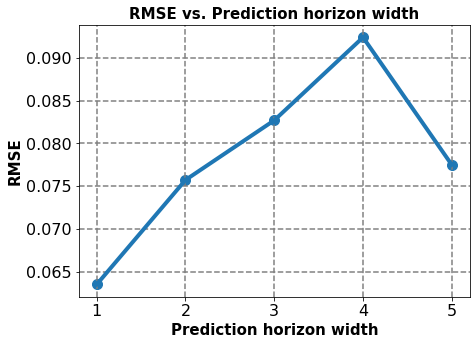

In [9]:
#Plot the output
fig, ax = plt.subplots(1,1)
fig.patch.set_facecolor('white')
plt.plot(x, s, linewidth=4)
plt.scatter(x, s, s=100)
ax.grid(color = 'gray', linestyle = '--', linewidth = 1.5)
ax.set_title('RMSE vs. Prediction horizon width',fontsize=15,weight = 'bold')
ax.set_xlabel('Prediction horizon width',fontsize=15,weight = 'bold')
ax.set_ylabel('RMSE',fontsize=15, weight = 'bold')
ax.tick_params(axis='both',labelsize=16)
ax.tick_params(axis = 'x', labelsize = 16)
ax.grid(True)
ax.set(facecolor = "white")
#plt.savefig('horizon5.png', dpi=450, orientation='portrait', bbox_inches='tight', facecolor='w',edgecolor='b',)
plt.show()

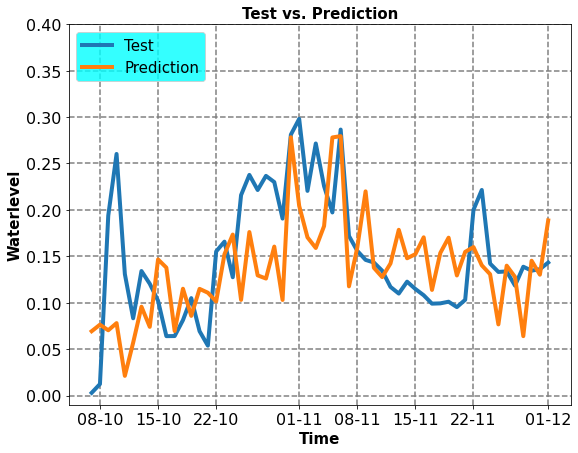

In [10]:
date_df = pd.read_csv('muringato-sensor6.csv')
df3 = date_df.tail(y_test.shape[0])
df4 = df3.drop(['Data'], axis = 1)
df4[['time']] = df4[['time']].apply(pd.to_datetime,dayfirst=True)
#Plot the output
plt.rcParams['figure.figsize'] = (9,7)
fig, ax = plt.subplots(1,1)
fig.patch.set_facecolor('white')
Test, = plt.plot(df4['time'],v,linewidth=4, label='label1')
Prediction, = plt.plot(df4['time'], u, linewidth=4, label='label1')
ax.grid(color = 'gray', linestyle = '--', linewidth = 1.5)
ax.set_title('Test vs. Prediction',fontsize=15,weight = 'bold')
ax.set_xlabel('Time',fontsize=15,weight = 'bold')
ax.set_ylabel('Waterlevel',fontsize=15, weight = 'bold')
ax.set_ylim(-0.01,0.4)
ax.tick_params(axis='both',labelsize=16)
ax.tick_params(axis = 'x', labelsize = 16)
ax.grid(True)
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.legend(["Test", "Prediction"], loc ="upper left", fancybox=True,facecolor='#01FFFF',prop={'size': 15,  'style': 'normal'})
ax.set(facecolor = "white")
#plt.savefig('lp2.png', dpi=450, orientation='portrait', bbox_inches='tight', facecolor='w',edgecolor='b',)
plt.show()